In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pandas as pd

In [2]:
class Network(nn.Module):
    def __init__(self, p1, p2, p3):
        super().__init__()
        self.features = nn.Sequential(
            nn.Linear(31, 70, bias= True),
            nn.SiLU(),
            nn.Linear(70, 70, bias= True),
            nn.SiLU(),
            nn.BatchNorm1d(70),
            nn.Dropout(p = p1),
            nn.Linear(70, 65, bias = True),
            nn.SiLU(),
            nn.Linear(65, 60, bias= True),
            nn.SiLU(),
            nn.Linear(60, 60, bias= True),
            nn.SiLU(),
            nn.BatchNorm1d(60),
            nn.Dropout(p= p2),
            nn.Linear(60, 55, bias= True),
            nn.SiLU(),
            nn.Linear(55, 50, bias= True),
            nn.SiLU(),
            nn.Linear(50, 45, bias= True),
            nn.SiLU(),
            nn.BatchNorm1d(45),
            nn.Dropout(p= p3),
            nn.Linear(45, 40, bias= True),
            nn.SiLU(),
            nn.Linear(40, 35, bias = True),
            nn.SiLU(),
            nn.Linear(35, 25, bias = True),
            nn.SiLU(),
            nn.Linear(25, 20, bias = True),
            nn.SiLU(),
            nn.Linear(20, 15, bias = True),
            nn.SiLU(),
            nn.Linear(15, 10, bias = True),
            nn.SiLU(),
            nn.Linear(10, 5, bias = True)
        )
        self.classify = nn.Sequential(
            nn.Linear(5, 1, bias= True),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.classify(self.features(x))

In [3]:
class Data(Dataset):
    def __init__(self, x, y):
        super().__init__()
        self.x = torch.tensor(x.values, dtype= torch.float32)
        self.y = torch.tensor(y.values, dtype= torch.float32)
    def __len__(self):
        return self.x.shape[0]
    def __getitem__(self, index):
        x, y = self.x[index], self.y[index]
        return x, y

In [4]:
xtrain, ytrain, xtest, ytest = pd.read_csv('./X_train.csv', header= None, index_col = None), pd.read_csv('./y_train.csv', header = None, index_col = None), pd.read_csv('./X_test.csv', header = None, index_col = None), pd.read_csv('./y_test.csv', header = None, index_col = None)
train_data = Data(x= xtrain, y= ytrain)
test_data = Data(x= xtest, y= ytest)
train_loader = DataLoader(train_data, batch_size=100, shuffle= True)
test_loader = DataLoader(test_data, batch_size= 100)

In [5]:
model = Network(0.3, 0.4, 0.5)
checkpoint = torch.load('./best_parameters_silu.pt', weights_only = False)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to('cuda')

In [6]:
criterion = nn.BCELoss()
# learning rate decreased by power of 10
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, weight_decay= 0.00001)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [7]:
loss_list_train, loss_list_val = [], []
for epoch in range(500):
    model.train()
    running_loss_trian, running_loss_val = 0.0, 0.0
    for input, target in train_loader:
        input, target = input.to('cuda'), target.to('cuda')
        optimizer.zero_grad()
        output = model(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        running_loss_trian += loss.item()
    model.eval()
    with torch.no_grad():
        for input, target in test_loader:
            input, target = input.to('cuda'), target.to('cuda')
            output = torch.round(model(input))
            loss = criterion(output, target)
            running_loss_val += loss.item()
    loss_list_train.append(running_loss_trian / len(train_loader))
    loss_list_val.append(running_loss_val / len(test_loader))
    print(f'Epoch - {epoch} loss - {running_loss_trian}')

Epoch - 0 loss - 2855.9068717956543
Epoch - 1 loss - 2853.703800678253
Epoch - 2 loss - 2854.587521135807
Epoch - 3 loss - 2857.3235569894314
Epoch - 4 loss - 2855.715415328741
Epoch - 5 loss - 2851.760130107403
Epoch - 6 loss - 2857.593063890934
Epoch - 7 loss - 2852.972002118826
Epoch - 8 loss - 2851.3531337976456
Epoch - 9 loss - 2859.9970045387745
Epoch - 10 loss - 2850.9788586199284
Epoch - 11 loss - 2854.6905398368835
Epoch - 12 loss - 2853.6042934060097
Epoch - 13 loss - 2856.2860695123672
Epoch - 14 loss - 2854.4483659267426
Epoch - 15 loss - 2855.470975100994
Epoch - 16 loss - 2852.42879191041
Epoch - 17 loss - 2856.0664679408073
Epoch - 18 loss - 2856.782133579254
Epoch - 19 loss - 2853.608320325613
Epoch - 20 loss - 2858.7854824364185
Epoch - 21 loss - 2852.557289838791
Epoch - 22 loss - 2851.249329715967
Epoch - 23 loss - 2852.367215335369
Epoch - 24 loss - 2852.156225055456
Epoch - 25 loss - 2852.332909822464
Epoch - 26 loss - 2856.424576371908
Epoch - 27 loss - 2853.25746

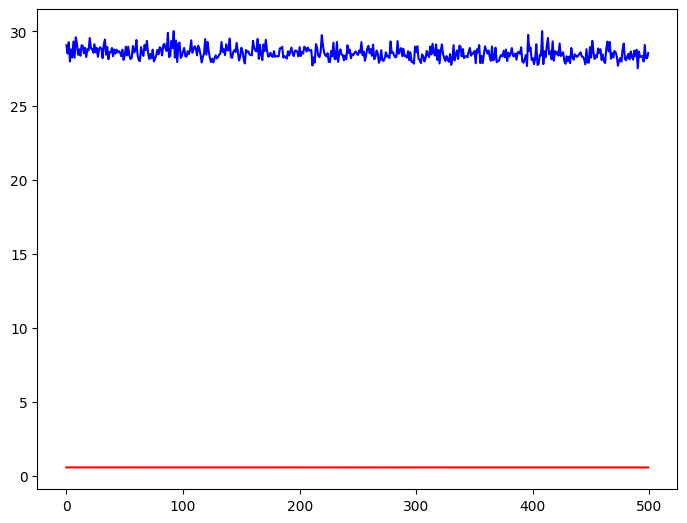

In [8]:
from matplotlib import pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
plt.plot(range(len(loss_list_train)), loss_list_train, color= 'red')
plt.plot(range(len(loss_list_val)), loss_list_val, color = 'blue')


In [9]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for input, target in test_loader:
        input, target = input.to('cuda'), target.to('cuda')
        output = torch.round(model(input))
        all_preds.extend(output.to('cpu'))
        all_labels.extend(target.to('cpu'))

from sklearn.metrics import accuracy_score
print(accuracy_score(all_preds, all_labels))


0.7144674142811078


In [10]:
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
print(recall_score(all_labels, all_preds))
print(precision_score(all_labels, all_preds))
print(f1_score(all_labels, all_preds))

0.547310524843852
0.6534587344871724
0.5956928696446236
